In [ ]:
## Notebook env: mirtud_env (R kernel)

In [1]:
library(readr)
library(readxl)
library(tidyverse)
library(ggplot2)
library(ggrepel)
library(tximport)
library(mygene)
library(DESeq2)
library(GenomicFeatures)
library(ensembldb)
library(AnnotationHub)



#BiocManager::install('clusterProfiler', lib = '/home/ssobti/projects/mir_tud/packages/gsea_R_pkgs')
#install.packages('genekitr', lib = '/home/ssobti/projects/mir_tud/packages/gsea_R_pkgs')
.libPaths('/home/ssobti/projects/mir_tud/packages/gsea_R_pkgs')
library(genekitr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ purrr     1.0.2
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: GenomicFeatures

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame,

In [2]:
## make gene annotations
txdb <- makeTxDbFromGFF(file = '/home/ssobti/genomes/hg38/gencode.v33.annotation.gtf.gz', dataSource = 'Gencode', organism = 'Homo sapiens')
k <- keys(txdb, keytype = "TXNAME")
tx2gene <- select(txdb, k, "GENEID", "TXNAME")

Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
"The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored."
OK

'select()' returned 1:1 mapping between keys and columns



In [3]:
## load in data ## 
files = list.files(path = '/home/ssobti/projects/mir_tud/wetlab_followup_data/bulk_rna_seq/raw/salmon_out/', pattern='quant.sf',full.names = TRUE, recursive = TRUE)
files = gsub(pattern = '//', replacement = '/', files)
file_sample_names = lapply(stringr::str_split(string = gsub(lapply(stringr::str_split(string = files, pattern = '/'), '[[', 10), pattern = '_salmon', replacement = ''), pattern = '_'), '[[', 1)
names(files) = file_sample_names

## since txOut is TRUE, transcript level informations (ie some genes have multiple unique transcripts and data is summarized at the transcript level)
txi = tximport(files, type = "salmon", tx2gene = tx2gene, txOut = TRUE)
txi.gene <- summarizeToGene(txi, tx2gene) ## this function summarizes the reads to gene level instead of transcript (so diff transcripts of same gene are consolidated) -- use this for analysis!!
sample_meta = read.csv('/home/ssobti/projects/mir_tud/wetlab_followup_data/bulk_rna_seq/TuD_bulkRNAseq_samplesheet.csv')
sample_meta = sample_meta %>% arrange(factor(Label, levels = colnames(txi.gene$counts)))
sample_meta$samplefactor = factor(sapply(stringr::str_split(sample_meta$Sample, '_'), '[[', 1))
colnames(txi.gene$counts) = colnames(txi.gene$abundance) = colnames(txi$abundance) = colnames(txi$counts) = sample_meta %>% pull(Sample) %>% as.character()

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 
22 
23 
24 
25 
26 
27 
28 
29 
30 
31 
32 
33 
34 
35 
36 
37 
38 
39 
40 


summarizing abundance

summarizing counts

summarizing length



In [4]:
## adding gene symbols to exp data ##
## obtain gene symbol database v99 ensembl to match v33 gencode
ah = AnnotationHub()
ensembl99 = query(ah, "EnsDb.Hsapiens.v99")
ensembl99 = ah[['AH78783']]

## add gene symbols
exp_data_counts = txi.gene$counts
gene_ids = sapply(str_split(rownames(exp_data_counts), pattern = '\\.'), '[[', 1)
geneIDs <- ensembldb::select(ensembl99, keys = gene_ids, keytype = "GENEID", columns = c("GENEID", "SYMBOL"))
exp_data_counts = cbind(geneIDs, exp_data_counts)

exp_data_tpm = txi.gene$abundance
gene_ids = sapply(str_split(rownames(exp_data_tpm), pattern = '\\.'), '[[', 1)
geneIDs <- ensembldb::select(ensembl99, keys = gene_ids, keytype = "GENEID", columns = c("GENEID", "SYMBOL"))
exp_data_tpm = cbind(geneIDs, exp_data_tpm)

## save the gene count data ##
## save the abunance and count data ##
path = '/home/ssobti/projects/mir_tud/wetlab_followup_data/bulk_rna_seq/annotated_expression/'

write.csv(exp_data_tpm, paste0(path,"gene_abundance_tpm_salmon.csv"), quote=FALSE)
write.csv(exp_data_counts, paste0(path,"gene_read_count_salmon.csv"), quote=FALSE)

loading from cache



In [5]:
## run DESeq2 ##
dds <- DESeqDataSetFromTximport(txi.gene, colData = sample_meta, design = ~ samplefactor)
dds <- DESeq(dds)
cc_samples = c('tRNA.Arg.CCT.3.1.lh', 'tRNA.Arg.ACG..3.1.1.2t', 'tRNA.Gln.TTG..3.3.1.2t', 'tRNA.Gly.TCC..6.2.1.2t', 'tRNA.Cys.GCA.4.1.2t')
control_samples = rep('NC1', length(cc_samples))

## extract results for cell cycle hits ##
res = list()
for (i in 1:length(cc_samples)){
  res[[i]] = results(dds, contrast = c('samplefactor', cc_samples[i], 'NC1')) %>% as.data.frame()
  gene_ids = sapply(str_split(rownames(res[[i]]), pattern = '\\.'), '[[', 1)
  gene_df = ensembldb::select(ensembl99, keys = gene_ids, keytype = "GENEID", columns = c("GENEID", "SYMBOL"))
  res[[i]]$symbol = gene_df$SYMBOL
}
names(res) = sample_meta %>% dplyr::filter(Class %in% 'Cell cycle/proliferation/apoptosis') %>% pull(samplefactor) %>% as.character() %>% unique()

## extract results for pca of samples ##
cds <- estimateDispersions(dds)
vsd <- varianceStabilizingTransformation(cds)
z <- plotPCA(vsd, intgroup=c("samplefactor"), returnData = TRUE)

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

using counts and average transcript lengths from tximport

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters

Warning message:
"ggrepel: 26 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


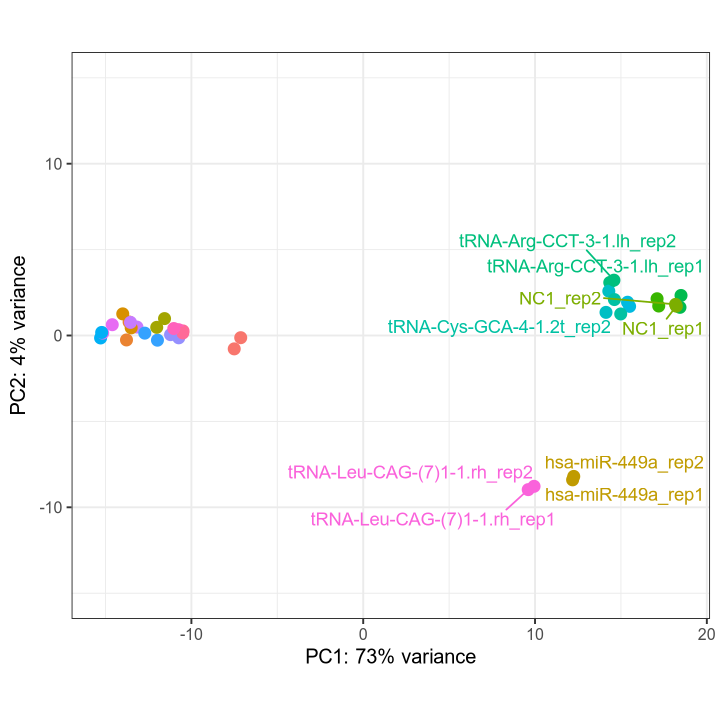

In [6]:
options(repr.plot.width = 6, repr.plot.height = 6)
percentVar <- round(100 * attr(z, "percentVar"))
ggplot(z, aes(PC1, PC2, color = samplefactor, label = name)) +
  geom_point(size=3, show.legend = F) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) +
  geom_text_repel(position = 'nudge', show.legend = F, max.overlaps = 20) +
  coord_fixed() + theme_bw(12) + ylim(-15,15) 


### Heatmap ###

In [7]:
## create curated gene sets ##
## G1 genes from GSEA website: https://www.gsea-msigdb.org/gsea/msigdb/cards/G1_PHASE
## S genes from GSEA website: https://www.gsea-msigdb.org/gsea/msigdb/human/geneset/S_PHASE
## G2 genes from GSEA website: https://www.gsea-msigdb.org/gsea/msigdb/cards/REACTOME_G2_PHASE
## Apoptosis genes from GSEA website: https://www.gsea-msigdb.org/gsea/msigdb/human/geneset/APOPTOTIC_PROGRAM

g1_genes = 'CDC23,CDC25C,CDC6,CDK10,CDK2,CDK6,CDKN1C,E2F1,FOXO4,GFI1B,MAP3K11,PRUNE2,RB1,TAF1,TBRG4'
s_genes = 'ABL1,APBB1,APBB2,CDC7,CDK2AP1,CHMP1A,DDX11,MYO16,POLA1,POLD1,PTPRC,RCC1,TIMELESS,TIPIN'
g2_genes = 'E2F1,E2F3,CDK2,CCNA1,CCNA2'
apoptosis_genes = 'ACIN1,AIFM1,AIFM3,APAF1,BAD,BAK1,BAX,BBC3,BCL2L1,BCL2L10,BID,BIK,BNIP3,CDIP1,CASP2,CASP3,CASP7,CASP8,CASP8AP2,CASP9,CDKN2A,CECR2,CIDEA,COL4A3,CYCS,DEDD2,DFFA,DFFB,DIABLO,DNM1L,F2,F2R,FOXL2,GPX1,GZMA,GZMB,HIP1,IFI6,IFNB1,IFT57,LCK,MCL1,MOAP1,MTCH1,NDUFA13,NLRC4,PDIA2,PMAIP1,PPT1,PSEN2,SFN,SMAD3,SOD1,STAT1,TNFSF15,TOP2A,TP53,TPD52L1,VCP,VDAC1'

g1_genes = unlist(strsplit(g1_genes, ","))
s_genes = unlist(strsplit(s_genes, ","))
g2_genes = unlist(strsplit(g2_genes, ","))
apoptosis_genes = unlist(strsplit(apoptosis_genes, ","))

In [8]:
filtered_res = lapply(res, function(x) x %>% dplyr::filter(symbol %in% g1_genes) %>% dplyr::select(symbol, log2FoldChange))
names(filtered_res) = names(res)
heatmap_data = as.data.frame(lapply(filtered_res, function(x) x$log2FoldChange))
colnames(heatmap_data) = names(filtered_res)
rownames(heatmap_data) = filtered_res[[1]]$symbol
heatmap_data = heatmap_data[rownames(heatmap_data) %in% c('GFI1B', 'CDKN1C', 'FOXO4'),]
heatmap_data = t(heatmap_data)
saveRDS(heatmap_data, '/home/ssobti/projects/mir_tud/fig_output/data/fig3/cc_heatmap_data.rds')

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



png 
  2

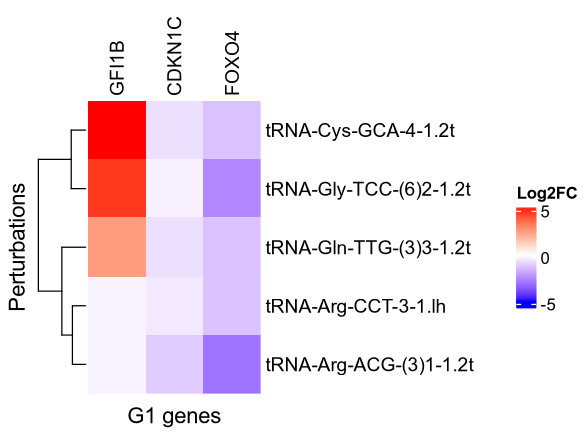

In [192]:
## tRF ##
library(ComplexHeatmap)
wfix = 4.9
hfix = 3.6

major_text_size = 8
minor_text_size = 8
lnwidth = 0.694

options(repr.plot.width = wfix, repr.plot.height = hfix)
## expected height in illustrator is 2.5
scale_factor = hfix/2.5 ## always divide height by height -- much less likely to change to make figure look better
heatmap_data = as.matrix(heatmap_data)
avg = mean(heatmap_data)
lower_bound = mean(heatmap_data) - 2*sd(heatmap_data)  ## tried 2 and 5 sd for different effects
upper_bound = mean(heatmap_data) + 2*sd(heatmap_data)

coloring_map <- circlize::colorRamp2(c(lower_bound, avg, upper_bound), c("blue", "white", "red"))

perturb_htmp <- function(matrix, title) {
  draw(Heatmap(matrix, name = title, show_column_names = TRUE, show_row_names = TRUE, show_column_dend = FALSE,
               col = coloring_map, show_row_dend = TRUE, use_raster = TRUE, row_title = 'Perturbations', 
               column_title = 'G1 genes', row_title_side = 'left', column_title_side = 'bottom', show_heatmap_legend = TRUE, column_names_side = "top", column_dend_side = "bottom",
               column_names_gp = gpar(fontfamily = "Helvetica", fontsize = minor_text_size*scale_factor), row_names_gp = gpar(fontfamily = "Helvetica", fontsize = minor_text_size*scale_factor)))
}

perturb_htmp(heatmap_data, 'Log2FC')

pdf('/home/ssobti/projects/mir_tud/notebooks/wetlab_followup/bulk_rna_seq/tRF_cellcycle_hits/G1.pdf', width = wfix, height = hfix)
perturb_htmp(heatmap_data, 'Log2FC')
dev.off()
#ggsave('/home/ssobti/projects/mir_tud/notebooks/wetlab_followup/bulk_rna_seq/tRF_cellcycle_hits/G1.pdf', width = wfix, height = hfix)
## our flow results show that G1/S transition is sped up -- depletion of cells in G1 phase ##
## GFI1B promotes G1/S transition by inhibiting G1 arrest -- upregulated here, should deplete cells in G1 https://pubmed.ncbi.nlm.nih.gov/8887656/ ##
## CDKN1C (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4389716/) and FOXO4 (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4063225/) arrest cells in G1 transition --  downregulated here, should deplete cells in G1 ##


In [194]:
filtered_res = lapply(res, function(x) x %>% dplyr::filter(symbol %in% s_genes) %>% dplyr::select(symbol, log2FoldChange))
names(filtered_res) = names(res)
heatmap_data = as.data.frame(lapply(filtered_res, function(x) x$log2FoldChange))
colnames(heatmap_data) = names(filtered_res)
rownames(heatmap_data) = filtered_res[[1]]$symbol
heatmap_data = heatmap_data[rownames(heatmap_data) %in% c('POLD1', 'DDX11'),]
heatmap_data = t(heatmap_data)

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



png 
  2

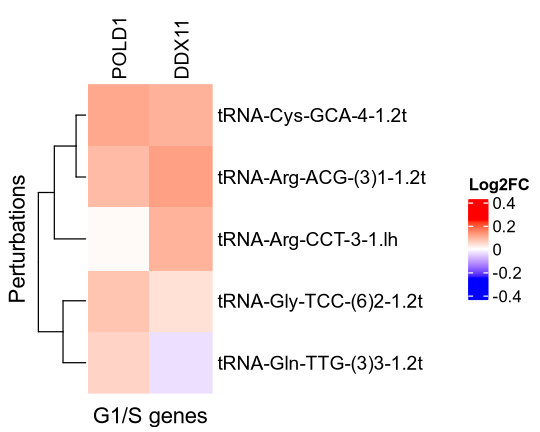

In [200]:
## tRF ##
library(ComplexHeatmap)
wfix = 4.5
hfix = 3.6

major_text_size = 8
minor_text_size = 8
lnwidth = 0.694

options(repr.plot.width = wfix, repr.plot.height = hfix)
## expected height in illustrator is 2.5
scale_factor = hfix/2.5 ## always divide height by height -- much less likely to change to make figure look better
heatmap_data = as.matrix(heatmap_data)
avg = 0
lower_bound = 0 - 5*sd(heatmap_data)  ## tried 2 and 5 sd for different effects
upper_bound = 0 + 5*sd(heatmap_data)

coloring_map <- circlize::colorRamp2(c(lower_bound, avg, upper_bound), c("blue", "white", "red"))

perturb_htmp <- function(matrix, title) {
  draw(Heatmap(matrix, name = title, show_column_names = TRUE, show_row_names = TRUE, show_column_dend = FALSE,
               col = coloring_map, show_row_dend = TRUE, use_raster = TRUE, row_title = 'Perturbations', 
               column_title = 'G1/S genes', row_title_side = 'left', column_title_side = 'bottom', show_heatmap_legend = TRUE, column_names_side = "top", column_dend_side = "bottom",
               column_names_gp = gpar(fontfamily = "Helvetica", fontsize = major_text_size*scale_factor), row_names_gp = gpar(fontfamily = "Helvetica", fontsize = major_text_size*scale_factor)))
}

perturb_htmp(heatmap_data, 'Log2FC')

pdf('/home/ssobti/projects/mir_tud/notebooks/wetlab_followup/bulk_rna_seq/tRF_cellcycle_hits/S.pdf', width = wfix, height = hfix)
perturb_htmp(heatmap_data, 'Log2FC')
dev.off()

## POLD1 and DDX11 upregulaiton facilitates G1/S transition https://www.nature.com/articles/s41467-023-38160-x, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6691710/


### GSEA ###

In [ ]:
res[[5]] %>% arrange(desc(log2FoldChange)) %>% head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,symbol
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000142449.13,4.713592,9.016136,9.245782,0.9751621,3.294799e-01,NA,FBN3
ENSG00000273003.1,21.907830,8.363884,2.370598,3.5281744,4.184363e-04,0.0199157634,ARL2-SNX15
ENSG00000241790.2,40.681239,8.255063,1.785077,4.6244847,3.755307e-06,0.0005480266,ENO1P4
ENSG00000176020.9,34.791343,8.148086,2.497733,3.2621921,1.105542e-03,0.0378905318,AMIGO3
ENSG00000263809.1,9.674373,7.528223,3.175453,2.3707560,1.775175e-02,0.2071758904,AC135178.3
ENSG00000268713.1,25.839982,7.512035,1.861923,4.0345581,5.470515e-05,0.0044929467,AC005261.4


In [ ]:
ranked_genes_1 = res[[5]] %>% arrange(desc(log2FoldChange)) %>% pull(log2FoldChange)
names(ranked_genes_1) = res[[5]] %>% arrange(desc(log2FoldChange)) %>% pull(symbol)
ranked_genes_1 = ranked_genes_1[!is.na(ranked_genes_1)]

In [ ]:
gs = list()
gs[['geneset']] = data.frame(mf = c(rep('G0:001', length(g1_genes)), rep('G0:002', length(s_genes)), rep('G0:003', length(g2_genes))), gene = c(g1_genes, s_genes, g2_genes))
gs[['geneset_name']] = data.frame(id = c('G0:001', 'G0:002', 'G0:003'), name = c('G1_geneset', 'S_geneset', 'G2_geneset'))
gs[['organism']] = 'hsapiens'
gs[['type']] = 'mf'

In [ ]:
gse <- genGSEA(genelist = ranked_genes_1, geneset = gs)

no term enriched under specific pvalueCutoff...



ERROR: Error in genGSEA(genelist = ranked_genes_1, geneset = gs): No terms enriched ...
